<a href="https://colab.research.google.com/github/noamiman/NBA_HOTHAND/blob/main/NBA_StatsAnalyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from nba_api.stats.endpoints import leaguedashplayerstats
import pandas as pd

# משיכת נתוני סטטיסטיקות כלליות לעונת 2024-25 (Regular Season)
stats = leaguedashplayerstats.LeagueDashPlayerStats(
    season='2024-25',
    season_type_all_star='Regular Season'
)

# הפיכת הנתונים ל־DataFrame
df_stats = stats.get_data_frames()[0]

df_stats['PPT'] = df_stats['PTS'] / df_stats['GP']

# סינון שחקנים עם ממוצע נק' מעל 20
df_over_20 = df_stats[(df_stats['PPT'] > 20) & (df_stats['GP'] > 60)]

df_top_players = df_over_20.sort_values(by='PPT', ascending=False).head(20)

df_top_Spesific = df_top_players[['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'PPT']]

arr_top = df_top_Spesific['PLAYER_ID'].tolist()
print(arr_top)


[1628983, 203507, 203999, 1630162, 1628369, 201142, 1630595, 1628973, 1626164, 201939, 1626157, 2544, 1629027, 1628378, 1629639, 1628368, 203897, 201935, 201942, 1627759]


In [ ]:
df_top_Spesific

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,PPT
490,1628983,Shai Gilgeous-Alexander,1610612760,OKC,32.684211
180,203507,Giannis Antetokounmpo,1610612749,MIL,30.388060
423,203999,Nikola Jokić,1610612743,DEN,29.585714
29,1630162,Anthony Edwards,1610612750,MIN,27.556962
263,1628369,Jayson Tatum,1610612738,BOS,26.833333
330,201142,Kevin Durant,1610612756,PHX,26.564516
69,1630595,Cade Cunningham,1610612765,DET,26.142857
226,1628973,Jalen Brunson,1610612752,NYK,26.000000
141,1626164,Devin Booker,1610612756,PHX,25.640000
498,201939,Stephen Curry,1610612744,GSW,24.542857


In [ ]:
from nba_api.stats.endpoints import shotchartdetail

In [ ]:
#columns = ['PLAYER_NAME', 'PLAYER_ID', 'ACCURACY_AFTER_MAKE', 'accuracy_after_miss', 'DIFFERNCE']
df_players_data = pd.DataFrame()
print(df_players_data)


Empty DataFrame
Columns: []
Index: []


In [ ]:
for id in arr_top:
  response = shotchartdetail.ShotChartDetail(
    player_id=id,
    team_id=0,  # 0 = כל הקבוצות
    season_type_all_star='Regular Season',
    season_nullable='2024-25',
    context_measure_simple='FGA'
    )
  df_shots = response.get_data_frames()[0]
  df_update = df_shots[['GAME_ID', 'GAME_EVENT_ID', 'PERIOD',  'MINUTES_REMAINING', 'SECONDS_REMAINING', 'SHOT_TYPE', 'SHOT_MADE_FLAG',]]
  df_update = df_update[df_update['SHOT_TYPE']=="3PT Field Goal"]
  player_name = df_top_Spesific[df_top_Spesific['PLAYER_ID']==id]['PLAYER_NAME'].to_string(index=False)
  print(f'player: {player_name}')
  print(df_update)
  # מיון הטבלה בסדר כרונולוגי הפוך – כי הזמן במשחק הולך לאחור
  df_update = df_update.sort_values(by=[
    'GAME_ID',
    'PERIOD',
    'MINUTES_REMAINING',
    'SECONDS_REMAINING'],
    ascending=[True, True, False, False])

# יצירת עמודה חדשה: האם הזריקה הקודמת נכנסה
  df_update['was_last_shot_made'] = df_update['SHOT_MADE_FLAG'].shift(1)

# אופציונלי: מאפסים את הערך בתחילת כל משחק
  df_update['prev_game_id'] = df_update['GAME_ID'].shift(1)
  df_update.loc[df_update['GAME_ID'] != df_update['prev_game_id'], 'was_last_shot_made'] = None

# ניקוי
  df_update.drop(columns=['prev_game_id'], inplace=True)
    # רק זריקות שיש להן זריקה קודמת (לא NaN)
  df_valid = df_update[df_update['was_last_shot_made'].notna()]

# קבוצה 1: זריקות אחרי קליעה
  after_make = df_valid[df_valid['was_last_shot_made'] == 1]

# קבוצה 2: זריקות אחרי החטאה
  after_miss = df_valid[df_valid['was_last_shot_made'] == 0]

# חישוב אחוזי קליעה
  accuracy_after_make = after_make['SHOT_MADE_FLAG'].mean()
  accuracy_after_miss = after_miss['SHOT_MADE_FLAG'].mean()
  difference = (accuracy_after_make - accuracy_after_miss)
# הדפסה

  print(df_update.head(50))
  print(f'🎯 אחוזי קליעה אחרי קליעה: {accuracy_after_make:.2%}')
  print(f'💥 אחוזי קליעה אחרי החטאה: {accuracy_after_miss:.2%}')
  print(f'📊 הפרש: {(accuracy_after_make - accuracy_after_miss):.2%}')

  df_players_data = pd.concat([df_players_data, pd.DataFrame({'player_name': [player_name], 'accuracy_after_make': [accuracy_after_make], 'accuracy_after_miss': [accuracy_after_miss], 'difference': [difference]})], ignore_index=True)

  time.sleep(1)


player: Shai Gilgeous-Alexander
         GAME_ID  GAME_EVENT_ID  PERIOD  MINUTES_REMAINING  SECONDS_REMAINING  \
2     0022400018             56       1                  7                 14   
5     0022400018            115       1                  2                 48   
8     0022400018            158       1                  0                 13   
10    0022400018            320       2                  2                 10   
11    0022400018            324       2                  1                 32   
...          ...            ...     ...                ...                ...   
1639  0022401230            125       1                  3                 23   
1641  0022401230            162       1                  0                 34   
1642  0022401230            170       1                  0                  0   
1649  0022401230            418       3                  7                 47   
1654  0022401230            625       4                  6                 36

In [ ]:
df_players_data

,player_name,accuracy_after_make,accuracy_after_miss,difference
0,Shai Gilgeous-Alexander,0.363636,0.370044,-0.006408
1,Giannis Antetokounmpo,0.125000,0.357143,-0.232143
2,Nikola Jokić,0.373832,0.423077,-0.049245
3,Anthony Edwards,0.399317,0.396355,0.002962
4,Jayson Tatum,0.345992,0.336516,0.009476
5,Kevin Durant,0.380597,0.471591,-0.090994
6,Cade Cunningham,0.376000,0.336323,0.039677
7,Jalen Brunson,0.351562,0.357843,-0.006281
8,Devin Booker,0.274854,0.349673,-0.074819
9,Stephen Curry,0.350340,0.414286,-0.063946


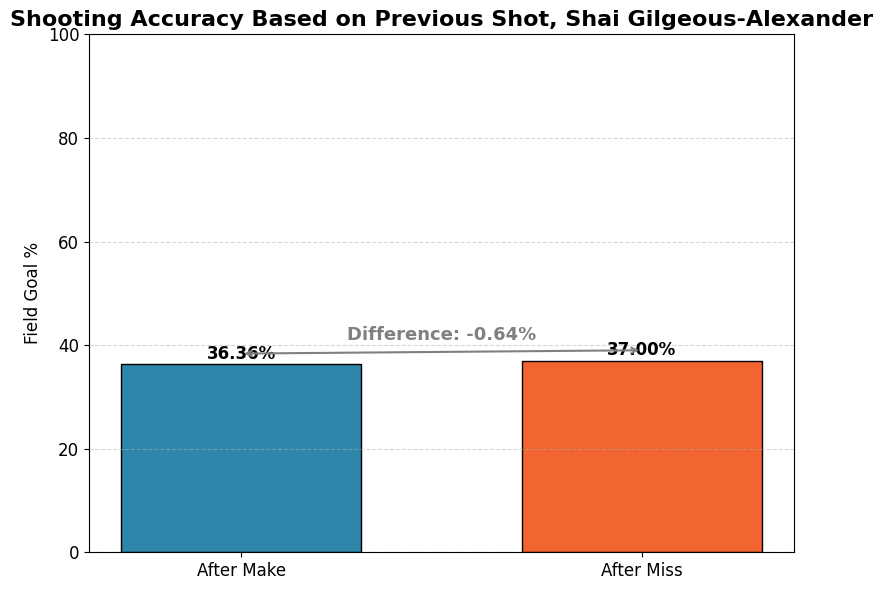

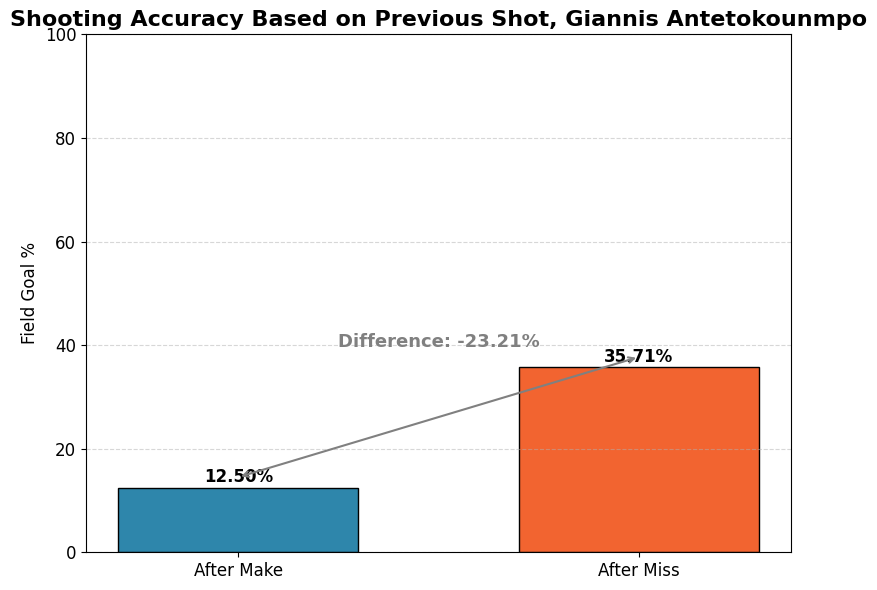

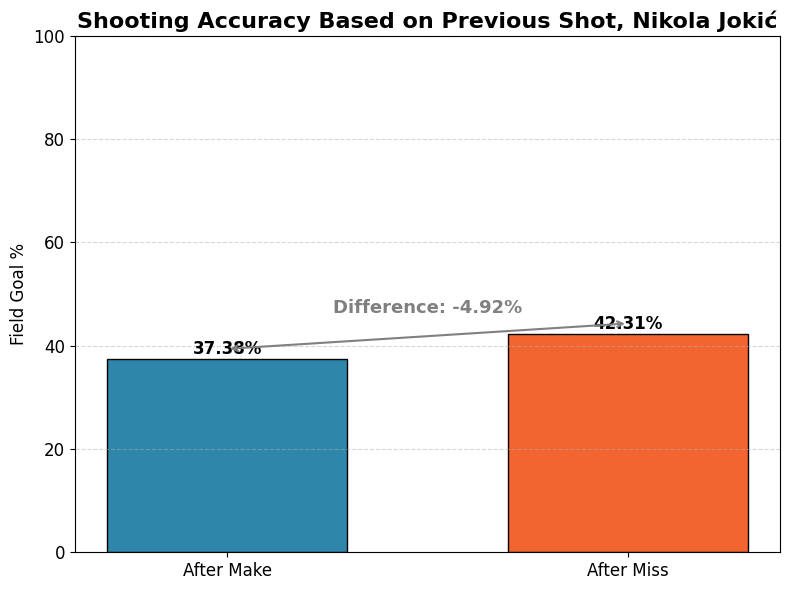

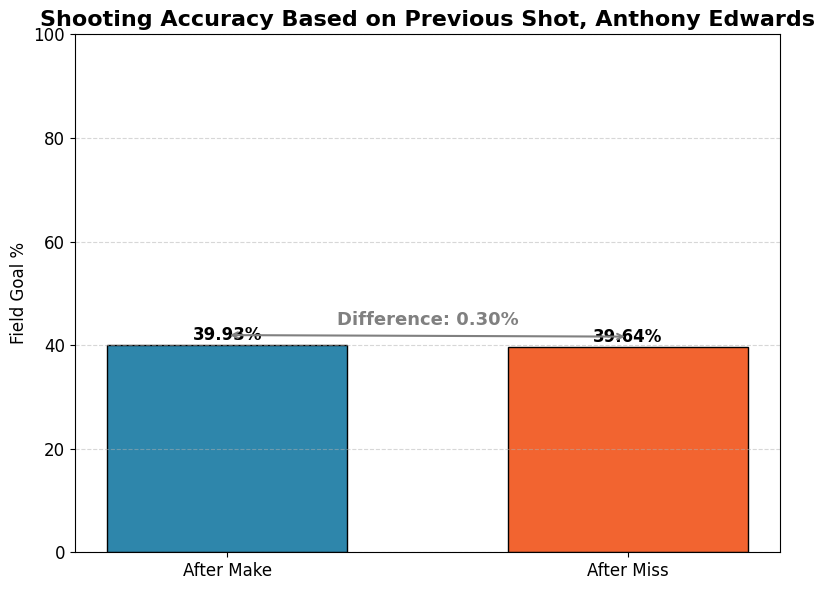

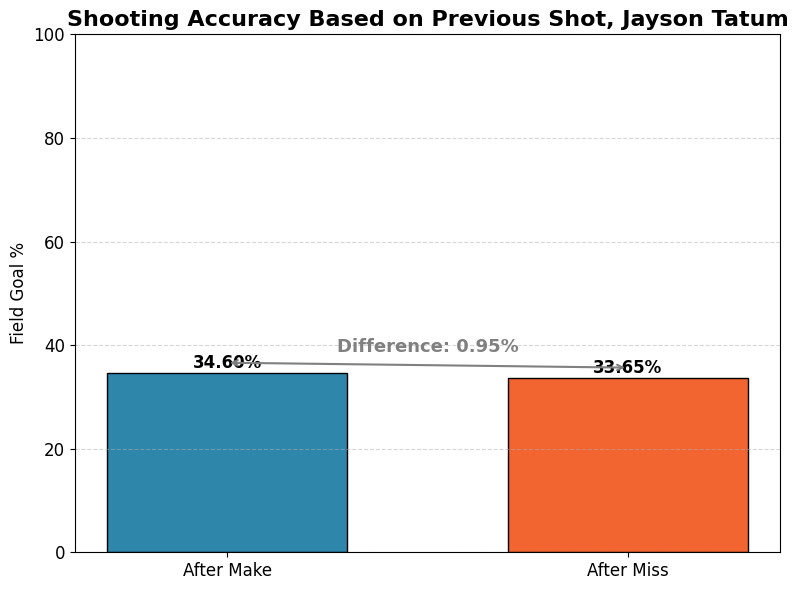

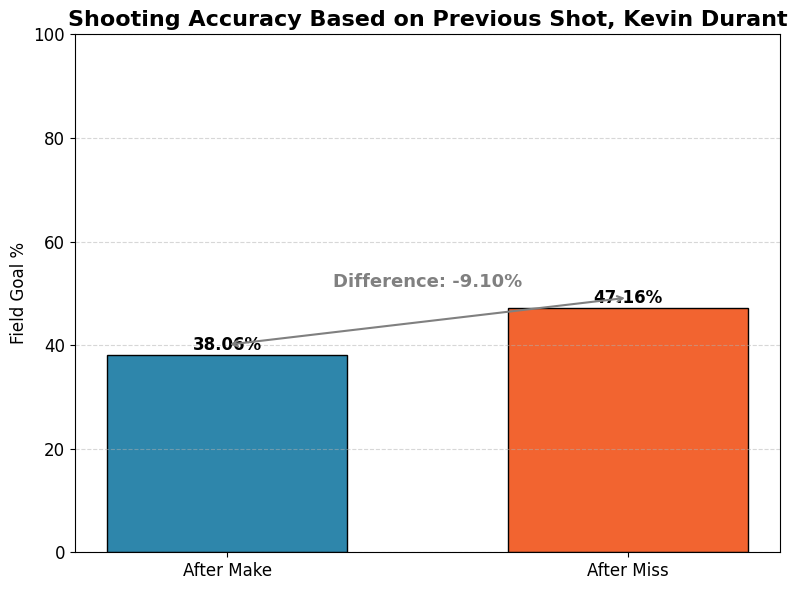

In [ ]:
for index, row in df_players_data.iterrows():
    player_name = row['player_name']
    accuracy_after_make = row['accuracy_after_make']*100
    accuracy_after_miss = row['accuracy_after_miss']*100
    diff = row['difference']*100

    labels = ['After Make', 'After Miss']
    values = [accuracy_after_make, accuracy_after_miss]
    colors = ['#2E86AB', '#F26430']  # Blue / Orange

# Create figure
    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, values, color=colors, width=0.6, edgecolor='black')

# Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2,
                height + 1,
                f'{height:.2f}%',
                ha='center',
                fontsize=12,
                weight='bold')

# Add double arrow showing the difference
    x1, x2 = 0, 1
    y1, y2 = values[0], values[1]
    y_arrow = max(y1, y2) + 2

    plt.annotate(
        '', xy=(x1, y1 + 2), xytext=(x2, y2 + 2),
        arrowprops=dict(arrowstyle='<->', lw=1.5, color='gray')
)

# Add difference text
    plt.text(0.5, y_arrow + 2,
            f'Difference: {diff:.2f}%',
            ha='center', fontsize=13, color='gray', weight='bold')

# Styling
    plt.title(f'Shooting Accuracy Based on Previous Shot, {player_name}', fontsize=16, weight='bold')
    plt.ylabel('Field Goal %', fontsize=12)
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()

    plt.show()